In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.integrate

C:\Users\jdavies\Anaconda3\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
class Bdots:
    def __init__(self, filename):
        data=np.transpose(np.genfromtxt(open(filename,"rb"),delimiter="\t", skip_footer=1, skip_header=1))
        self.data=data
        self.time_raw=data[0]
        #rogowski signals 1 and 2
        self.bdots_raw=data[1:]
    def truncate(self, signal=0, threshold=1.0, calibration=None):
        if calibration is None:
            calibration=np.zeros_like(self.bdots_raw)+1.0
        #find the start of the current pulse with a  high threshold
        sig1=self.bdots_raw[signal]
        start=np.nonzero(abs(sig1)>threshold)[0][0]
        #back off a bit so we can see the zero signal
        self.start=start-100
        #reverse the array to find the end of the current pulse with a high threshold
        end=np.nonzero(abs(sig1[::-1])>threshold)[0][0]
        #back off a bit so we can see the zero signal
        end=end-100
        self.end=sig1.size-end #find the index in the non-reversed array
        self.time=self.time_raw[self.start:self.end]
        self.bdots_tr=[]
        for br, cal in zip(self.bdots_raw, calibration):
            self.bdots_tr.append(br[self.start:self.end]*cal)
    def add(self):
        self.estat=[]
        for i in np.arange(0,len(self.bdots_tr)-1,2):
            self.estat.append((self.bdots_tr[i]+self.bdots_tr[i+1])/2.0)         
    def subtract(self):
        self.dBdt=[]
        for i in np.arange(0,len(self.bdots_tr)-1,2):
            self.dBdt.append((self.bdots_tr[i]-self.bdots_tr[i+1])/2.0)
    def plot_raw(self):
        self.fig_raw, self.ax_raw=plt.subplots()
        for r in self.bdots_raw:
            self.ax_raw.plot(self.time_raw, r)
    def plot_tr(self):
        self.fig_tr, self.ax_tr=plt.subplots()
        for tr in self.bdots_tr:
            self.ax_tr.plot(self.time, tr)
    def plot_dBdt(self):
        self.fig_dB, self.ax_dB=plt.subplots()
        for dB in self.dBdt:
            self.ax_dB.plot(self.time, dB)
    def plot_estat(self):
        self.fig_dB, self.ax_dB=plt.subplots()
        for es in self.estat:
            self.ax_dB.plot(self.time, es)
    def integrate(self):
        self.B=[scipy.integrate.cumtrapz(b,self.time)/1e9 for b in self.dBdt]
        self.time_B=self.time[:-1]
    def plot_B(self):
        self.fig_B, self.ax_B=plt.subplots()
        for i, b in enumerate(self.B):
            self.ax_B.plot(self.time_B, b, label='Pair '+str(i))
            self.ax_B.legend()


In [3]:
scope_channels={'a1':1,'a2':2,'b1':3,'b2':4,'c1':5, 'c2':6, 'd1':7, 'd2':8}

class Bdot_pair:
    def __init__(self, filename, bdot1='a1', bdot2='a2'):
        data=np.transpose(np.genfromtxt(open(filename,"rb"),delimiter="\t", skip_footer=1, skip_header=1))
        self.data=data
        self.time_raw=data[0]
        #rogowski signals 1 and 2
        self.bd1_raw=data[scope_channels[bdot1],:]
        self.bd2_raw=data[scope_channels[bdot2],:]
    def truncate(self, threshold=1.0, window=1000, calibration=None):
        if calibration is None:
            calibration=np.zeros_like(self.bdots_raw)+1.0
        #find the start of the current pulse with a  high threshold
        sig1=self.bd1_raw
        start=np.nonzero(abs(sig1)>threshold)[0][0]
        #back off a bit so we can see the zero signal
        self.start=start-100
        #reverse the array to find the end of the current pulse with a high threshold
        #end=np.nonzero(abs(sig1[::-1])>threshold)[0][0]
        #back off a bit so we can see the zero signal
        #end=end-100
        #self.end=sig1.size-end #find the index in the non-reversed array
        self.time=self.time_raw[self.start:self.start+window]
        self.bd1_tr=self.bd1_raw[self.start:self.start+window]*cal[0]
        self.bd2_tr=self.bd2_raw[self.start:self.start+window]*cal[1]
    def add(self):
        self.estat=(self.bd1_tr+self.bd2_tr)/2.0      
    def subtract(self):
        self.dBdt=(self.bd1_tr-self.bd2_tr)/2.0
    def plot_raw(self):
        self.fig, self.ax=plt.subplots()
        self.ax.plot(self.time_raw, self.bd1_raw, label='Bdot 1, raw')
        self.ax.plot(self.time_raw, self.bd2_raw, label='Bdot 2, raw')
        self.ax.legend()
    def plot_tr(self):
        self.fig, self.ax=plt.subplots()
        self.ax.plot(self.time, self.bd1_tr, label='Bdot 1, truncated')
        self.ax.plot(self.time, self.bd2_tr, label='Bdot 2, truncated')
        self.ax.legend()
    def plot_dBdt(self):
        self.fig, self.ax=plt.subplots()
        self.ax.plot(self.time, self.dBdt, label='dB/dt')
        self.ax.legend()
    def plot_estat(self):
        self.fig, self.ax=plt.subplots()
        self.ax.plot(self.time, self.estat, label='Electrostatic')
        self.ax.legend()
    def plot_estat_dBdt(self):
        self.fig, self.ax=plt.subplots()
        self.ax.plot(self.time, self.dBdt, label='dB/dt')
        self.ax.plot(self.time, self.estat, label='Electrostatic')
        self.ax.legend()
    def integrate(self):
        self.B=scipy.integrate.cumtrapz(self.dBdt,self.time)/1e9
        self.time_B=self.time[:-1]
    def plot_B(self):
        self.fig, self.ax=plt.subplots()
        self.ax.plot(self.time_B, self.B, label='Magnetic Field')
        self.ax.legend()

In [49]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0202_16 C RECONNECTION Bdots

C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0202_16 C RECONNECTION Bdots


In [70]:
cal=np.array([10.8/np.pi,9.7/np.pi, 10/np.pi,9.8/np.pi, 10.8/0.2, 10.6/0.2, 10/0.2,10/0.2])*1e6
bd=Bdots("s0202_16 bdots.dat")

<IPython.core.display.Javascript object>


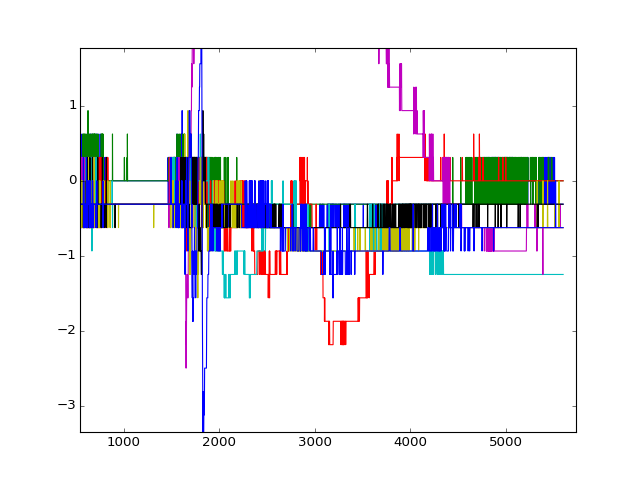

In [52]:
bd.plot_raw()

In [71]:
bd.truncate(signal=5,threshold=1,calibration=cal)
bd.add()
bd.subtract()

<IPython.core.display.Javascript object>


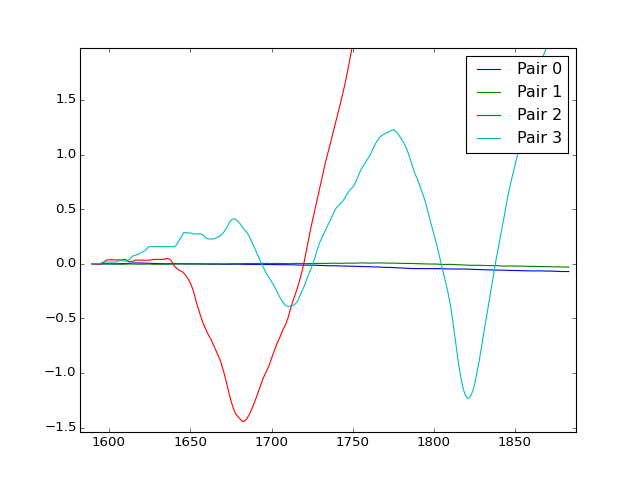

In [72]:
bd.integrate()
bd.plot_B()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


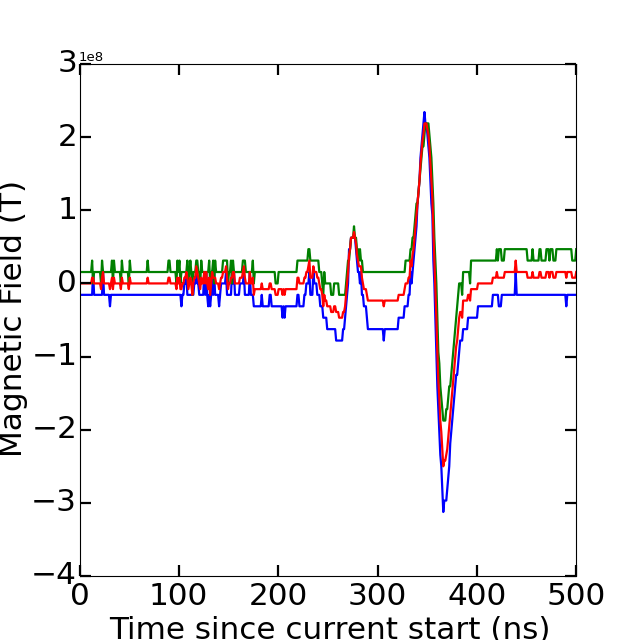

In [45]:
fig, ax=plt.subplots(figsize=(8,8))
ax.plot(bd.time-1530, bd.bdots_tr[4], lw=2)
ax.plot(bd.time-1530, -bd.bdots_tr[5], lw=2)
ax.plot(bd.time-1530, bd.dBdt[2], lw=2)
#ax.plot(bd.time_B-1530, bd.B[1], lw=2,label='Left pair')
ax.set_xlim([0,500])
#ax.set_ylim([-1,8])
ax.set_xlabel('Time since current start (ns)', fontsize=28)
ax.set_ylabel('Magnetic Field (T)', fontsize=28)

ax.tick_params(labelsize=28, pad=5, length=10, width=2)

#ax.legend(fontsize=20)


In [43]:
bd.integrate()

In [113]:
bd.subtract()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


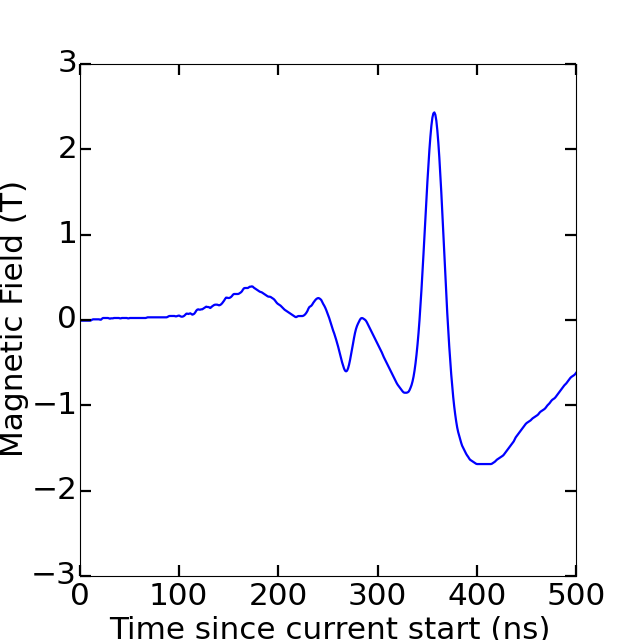

In [44]:
fig, ax=plt.subplots(figsize=(8,8))
ax.plot(bd.time_B-1530, bd.B[2], lw=2)
ax.set_xlim([0,500])
ax.set_ylim([-3,3])
ax.set_xlabel('Time since current start (ns)', fontsize=28)
ax.set_ylabel('Magnetic Field (T)', fontsize=28)

ax.tick_params(labelsize=28, pad=5, length=10, width=2)

#ax.legend(fontsize=20)

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


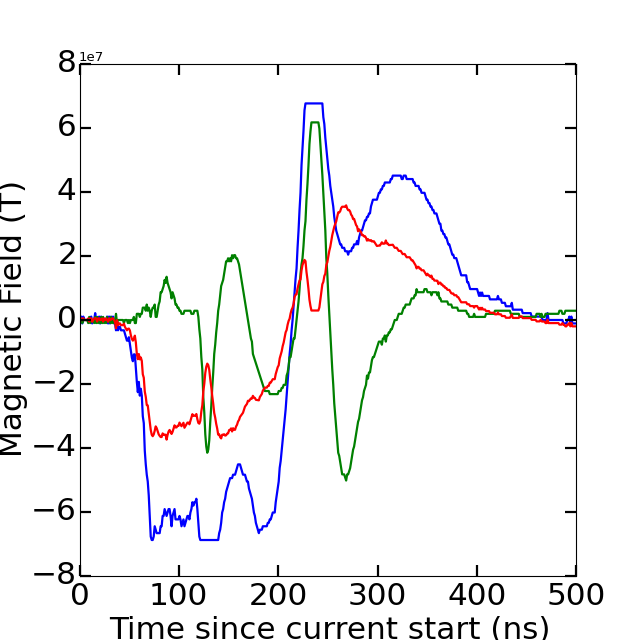

In [208]:
fig, ax=plt.subplots(figsize=(8,8))
ax.plot(bd.time-1530, bd.bdots_tr[0], lw=2)
ax.plot(bd.time-1530, -bd.bdots_tr[1], lw=2)
ax.plot(bd.time-1530, (bd.bdots_tr[0]+bd.bdots_tr[1])/2.0, lw=2)

ax.set_xlim([0,500])
#ax.set_ylim([-1,8])
ax.set_xlabel('Time since current start (ns)', fontsize=28)
ax.set_ylabel('Magnetic Field (T)', fontsize=28)

ax.tick_params(labelsize=28, pad=5, length=10, width=2)



## s0125B16

In [93]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0125B16 C RECONNECTION 12 FRAME + BDots"

C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0125B16 C RECONNECTION 12 FRAME + BDots


C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


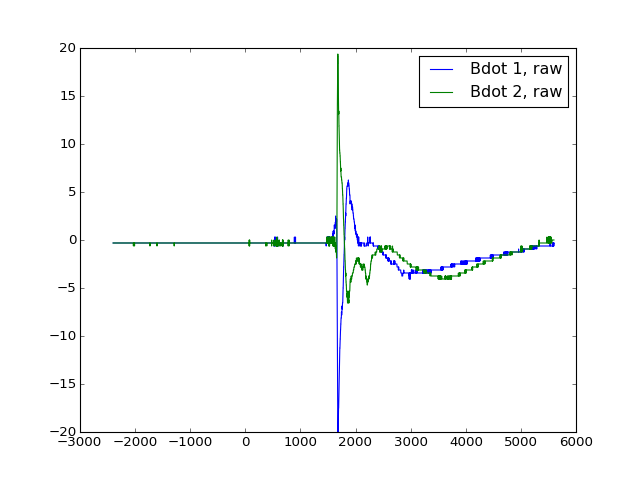

In [122]:
cal=np.array([1/0.2, 1/0.2])*1e6
bd=Bdot_pair("s0125B16 bdots.dat", bdot1='c1', bdot2='c2')
bd.plot_raw()

In [123]:
bd.truncate(threshold=1,calibration=cal)
bd.add()
bd.subtract()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


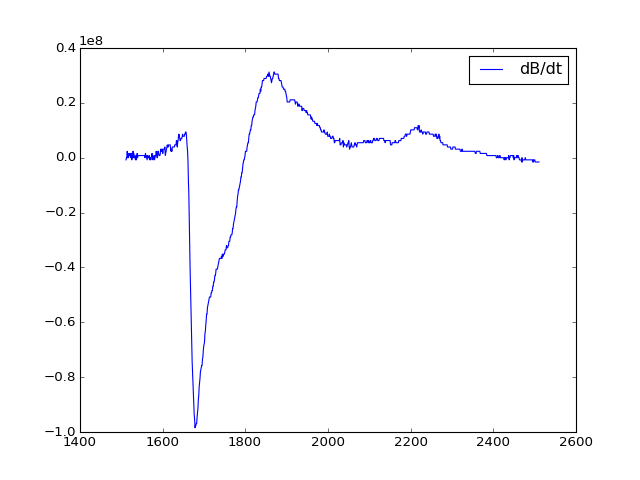

<IPython.core.display.Javascript object>


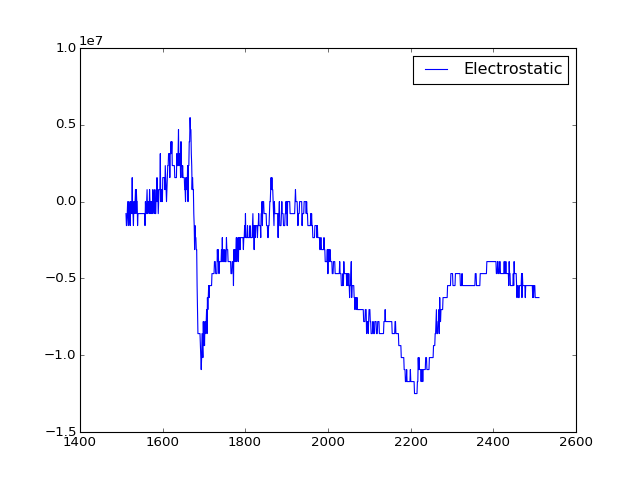

In [126]:
bd.plot_dBdt()
bd.plot_estat()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


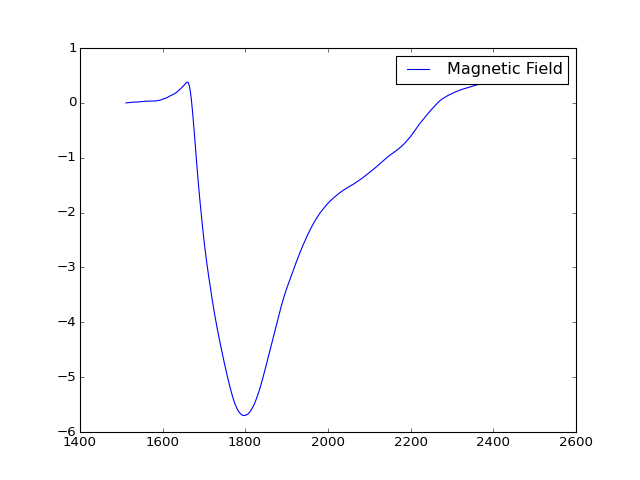

In [125]:
bd.integrate()
bd.plot_B()

## s0125_16

In [133]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0125_16 C RECONNECTION 12 FRAME"

C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0125_16 C RECONNECTION 12 FRAME


C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


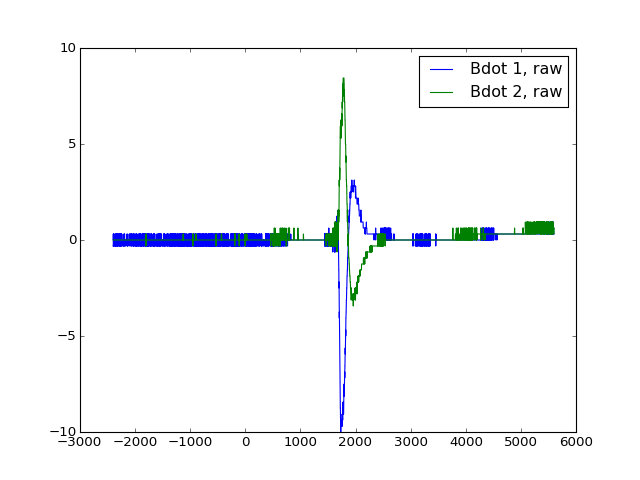

In [134]:
cal=np.array([10.8/np.pi, 10.6/np.pi])*1e6
bd=Bdot_pair("s0125_16 bdots.dat", bdot1='a1', bdot2='a2')
bd.plot_raw()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


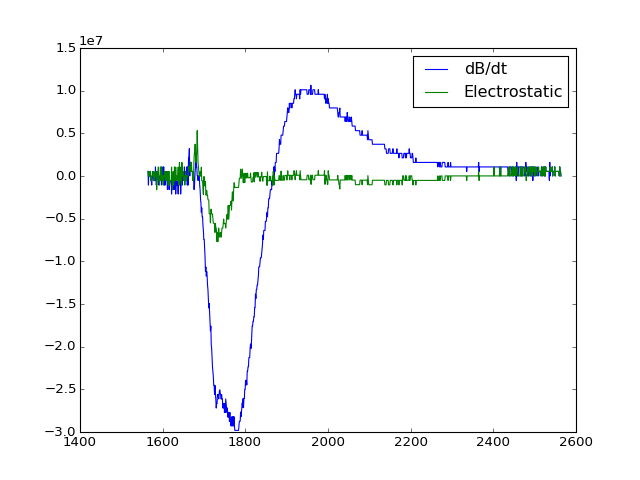

In [135]:
bd.truncate(threshold=1,calibration=cal)
bd.add()
bd.subtract()
bd.plot_estat_dBdt()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


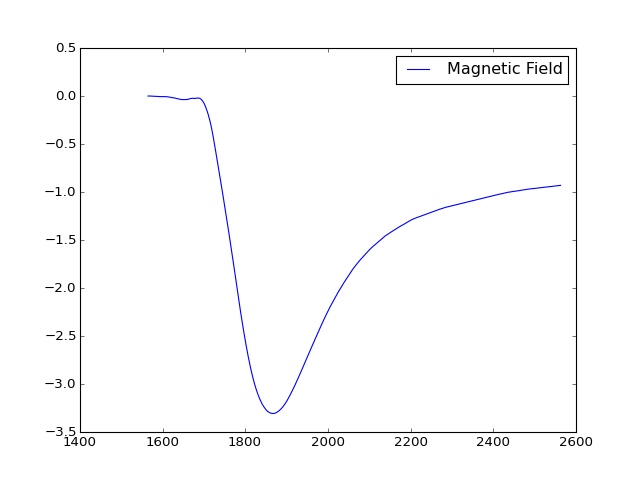

In [136]:
bd.integrate()
bd.plot_B()

In [ ]:
top_hat=np.zeros_like(bd.time)
np.convolve

## s0205_16

In [3]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\Others"

C:\Users\jdavies\Google Drive\MAGPIE\data\Others


<IPython.core.display.Javascript object>


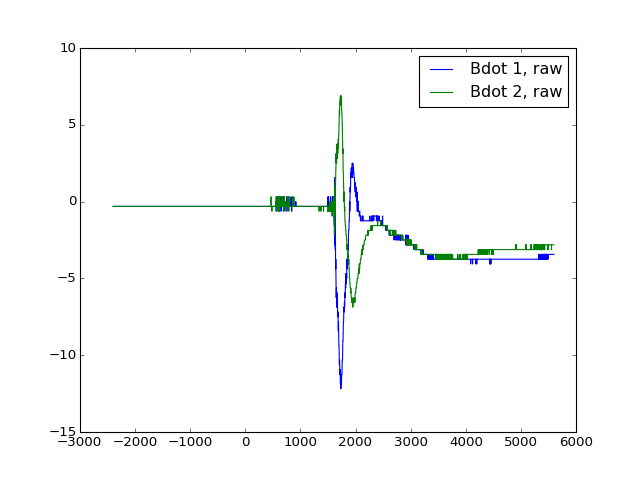

In [4]:
cal=np.array([1/0.2, 1/0.2])*1e6
bd=Bdot_pair("s0205_16 bdots.dat", bdot1='b1', bdot2='b2')
bd.plot_raw()

<IPython.core.display.Javascript object>


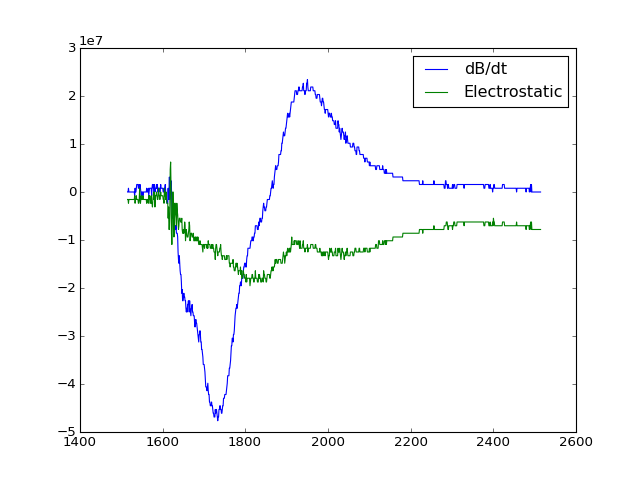

In [5]:
bd.truncate(threshold=1,calibration=cal)
bd.add()
bd.subtract()
bd.plot_estat_dBdt()

<IPython.core.display.Javascript object>


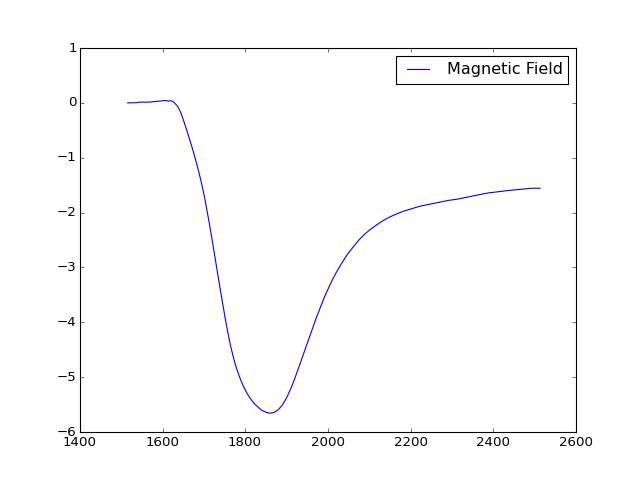

In [6]:
bd.integrate()
bd.plot_B()

## s0210_16

In [4]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\Others"

C:\Users\jdavies\Google Drive\MAGPIE\data\Others


<IPython.core.display.Javascript object>


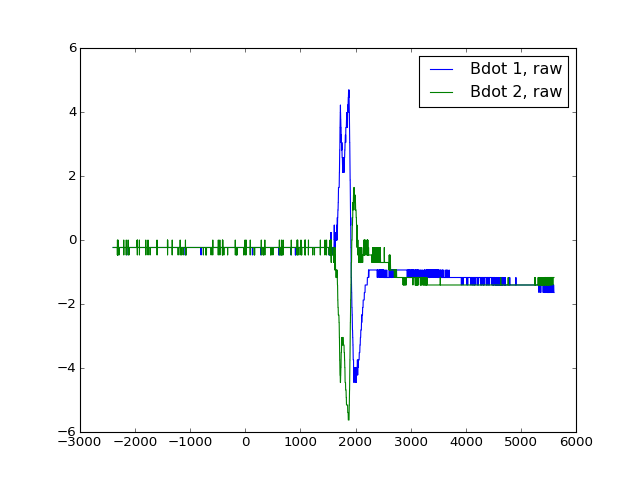

In [11]:
cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6
bd=Bdot_pair("s0210_16 bdots.dat", bdot1='c1', bdot2='c2')
bd.plot_raw()

<IPython.core.display.Javascript object>


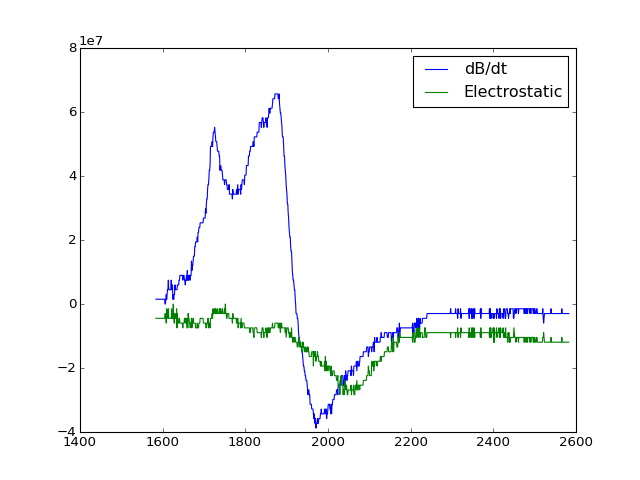

<IPython.core.display.Javascript object>


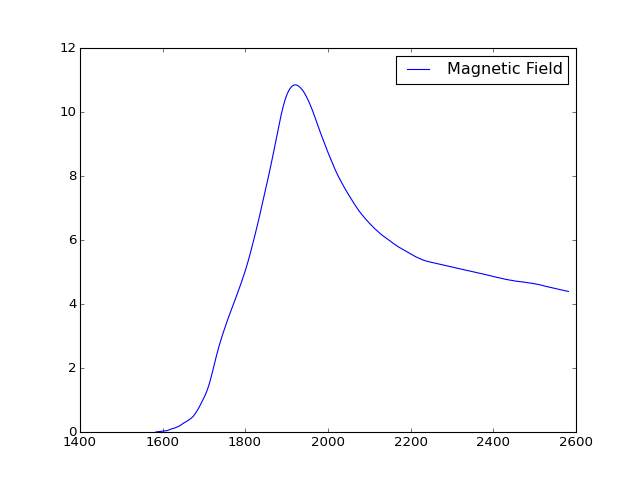

In [14]:
bd.truncate(threshold=1,calibration=cal)
bd.add()
bd.subtract()
bd.plot_estat_dBdt()
bd.integrate()
bd.plot_B()

<IPython.core.display.Javascript object>


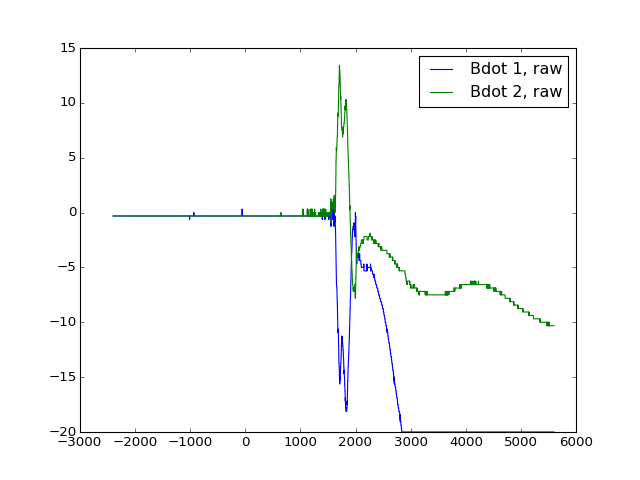

In [18]:
cal=-np.array([1/(0.2), 1/(0.2)])*1e6
bd=Bdot_pair("s0210_16 bdots.dat", bdot1='b1', bdot2='b2')
bd.plot_raw()

<IPython.core.display.Javascript object>


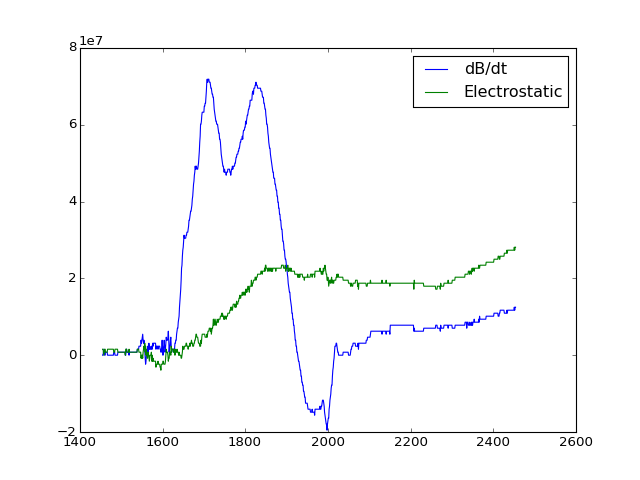

<IPython.core.display.Javascript object>


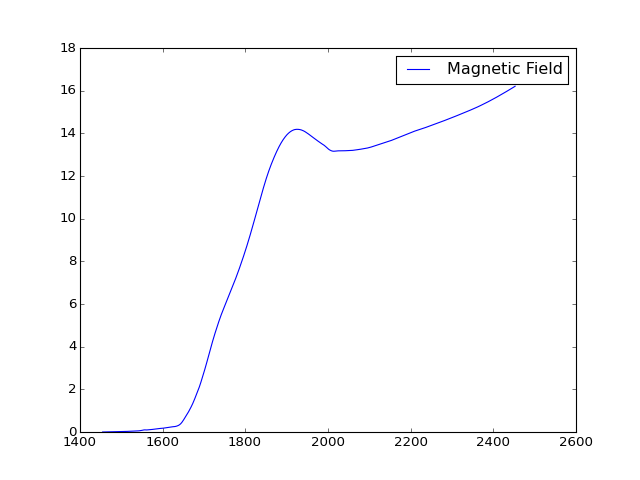

In [19]:
bd.truncate(threshold=1,calibration=cal)
bd.add()
bd.subtract()
bd.plot_estat_dBdt()
bd.integrate()
bd.plot_B()

## s0211_16

In [23]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\Others"

C:\Users\jdavies\Google Drive\MAGPIE\data\Others


C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


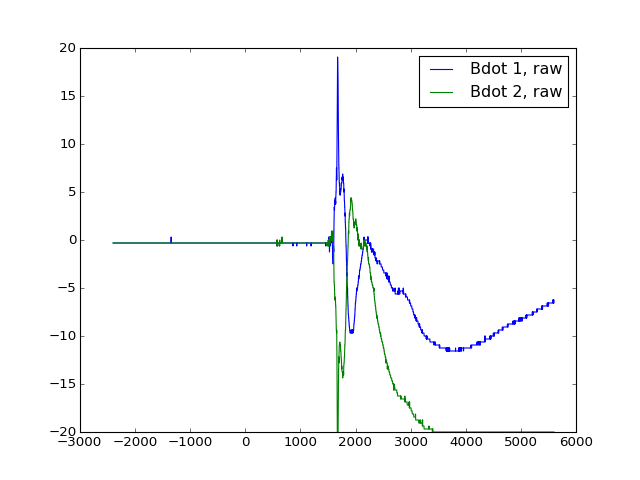

In [77]:
#cal=-np.array([21/np.pi, 20/np.pi])*1e6 #a1 and a2
cal=-np.array([1/0.2, 1/0.2])*1e6 #b1 and b2 and d1 and d2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6 #c1 and c2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6
bd=Bdot_pair("s0211_16 bdots.dat", bdot1='d1', bdot2='d2')
bd.plot_raw()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


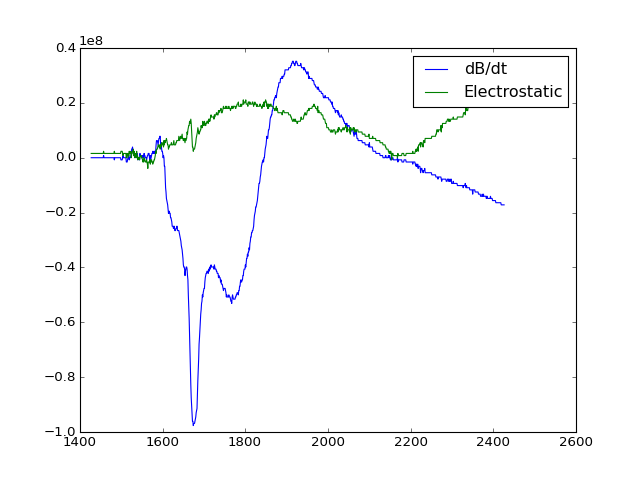

<IPython.core.display.Javascript object>


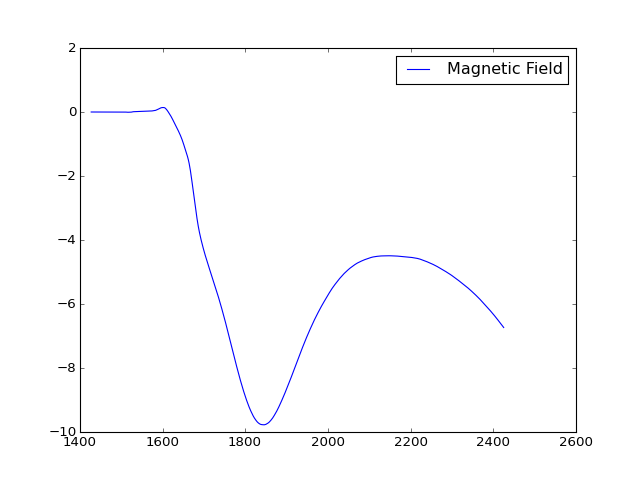

In [78]:
bd.truncate(threshold=1,calibration=cal)
bd.add()
bd.subtract()
bd.plot_estat_dBdt()
bd.integrate()
bd.plot_B()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


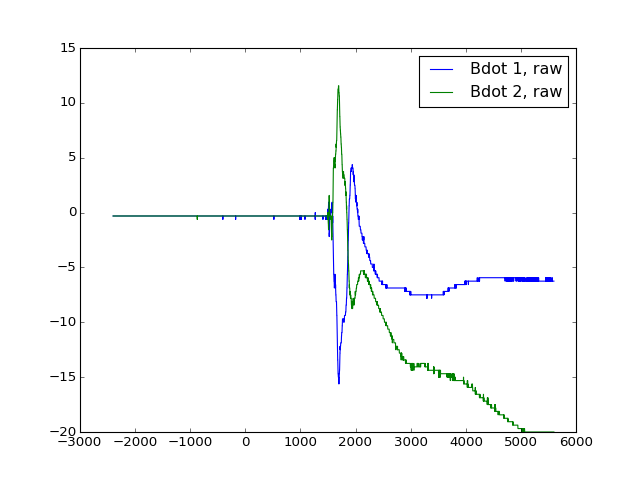

In [61]:
#cal=-np.array([21/np.pi, 20/np.pi])*1e6 #a1 and a2
cal=-np.array([1/0.2, 1/0.2])*1e6 #b1 and b2 and d1 and d2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6 #c1 and c2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6
bd2=Bdot_pair("s0211_16 bdots.dat", bdot1='b1', bdot2='b2')
bd2.plot_raw()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


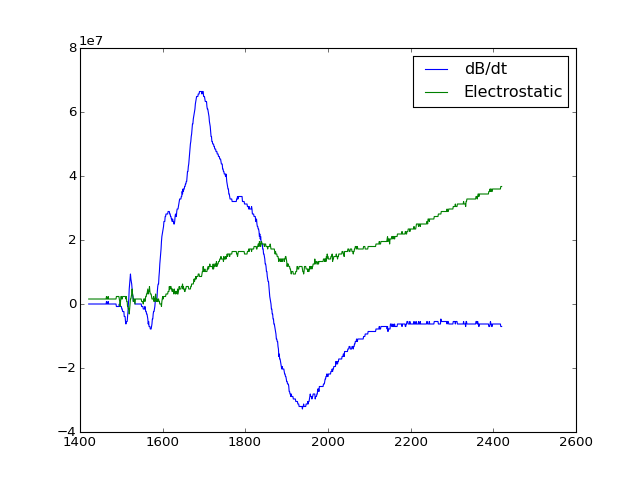

<IPython.core.display.Javascript object>


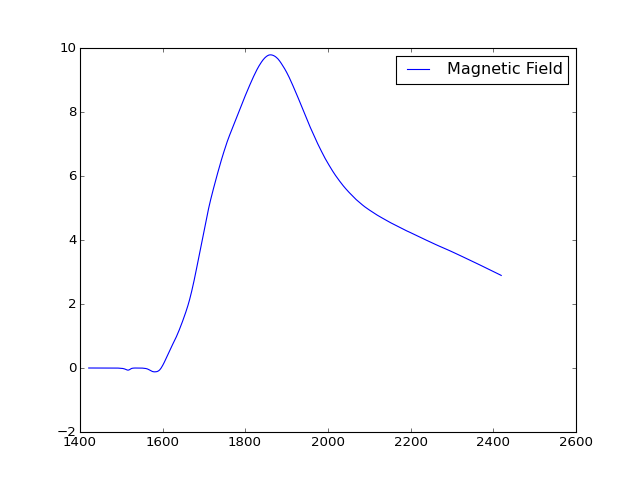

In [62]:
bd2.truncate(threshold=1,calibration=cal)
bd2.add()
bd2.subtract()
bd2.plot_estat_dBdt()
bd2.integrate()
bd2.plot_B()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


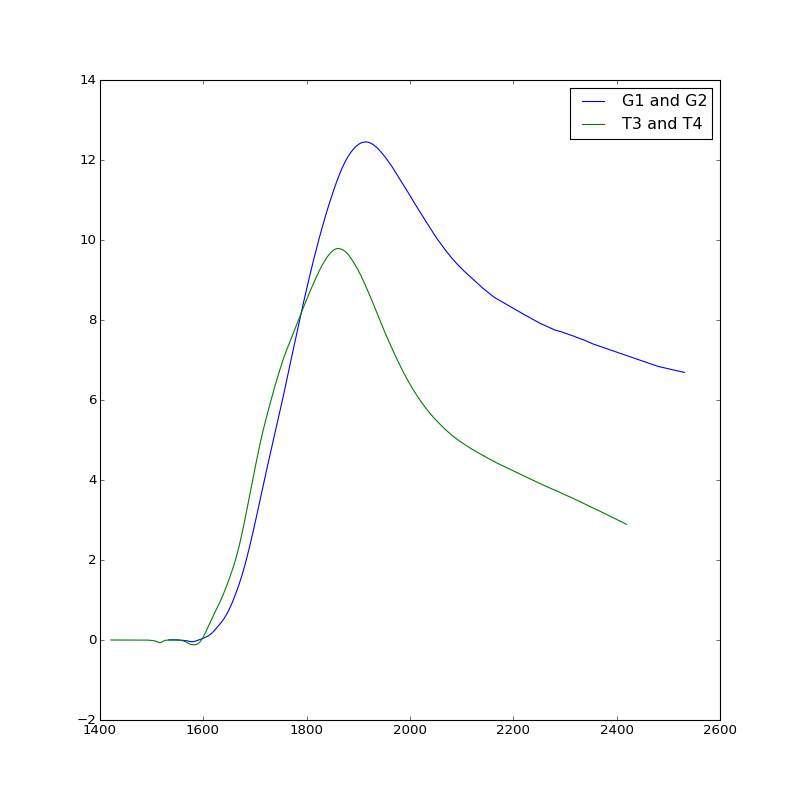

In [63]:
fig, ax=plt.subplots(figsize=(10,10))
ax.plot(bd.time_B,bd.B, label='G1 and G2')
ax.plot(bd2.time_B,bd2.B, label='T3 and T4')
ax.legend()

## s0614_13

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


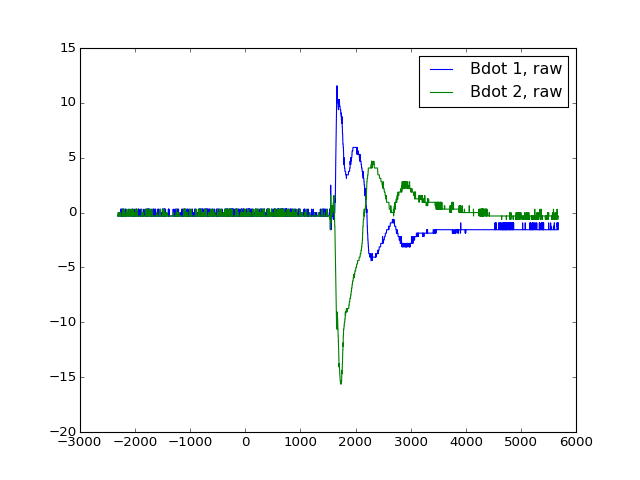

In [69]:
#cal=-np.array([20/2.7, 20/2.7])*1e6 #a1 and a2
cal=np.array([10/3.1, 10/3.1])*1e6 #b1 and b2 and d1 and d2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6 #c1 and c2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6
bd3=Bdot_pair("s0614_13 bdots.dat", bdot1='b1', bdot2='b2')
bd3.plot_raw()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


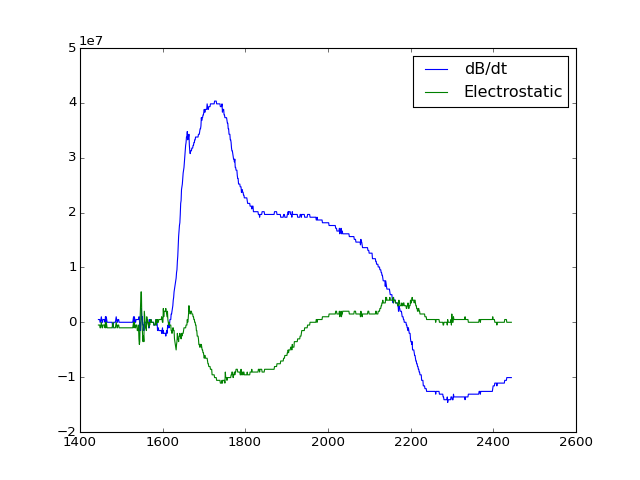

<IPython.core.display.Javascript object>


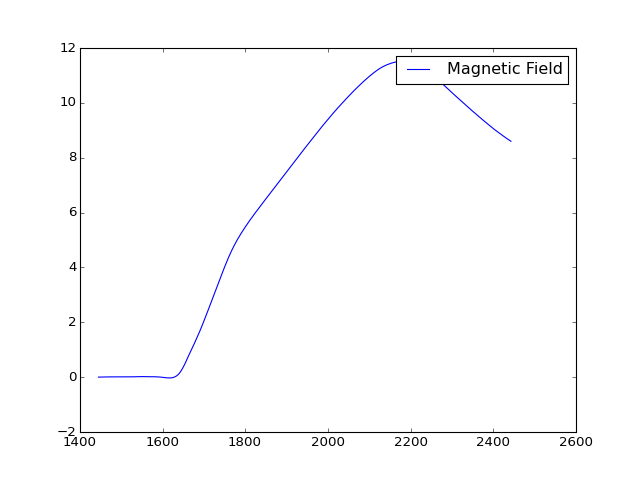

In [70]:
bd3.truncate(threshold=1,calibration=cal)
bd3.add()
bd3.subtract()
bd3.plot_estat_dBdt()
bd3.integrate()
bd3.plot_B()

## s0724_13

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


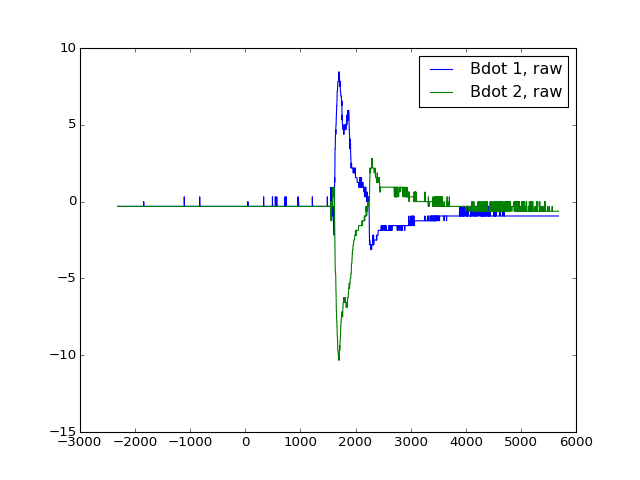

In [72]:
#cal=-np.array([20/2.7, 20/2.7])*1e6 #a1 and a2
cal=np.array([10/3.1, 10/3.1])*1e6 #b1 and b2 and d1 and d2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6 #c1 and c2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6
bd3=Bdot_pair("s0724_13 bdots.dat", bdot1='b1', bdot2='b2')
bd3.plot_raw()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


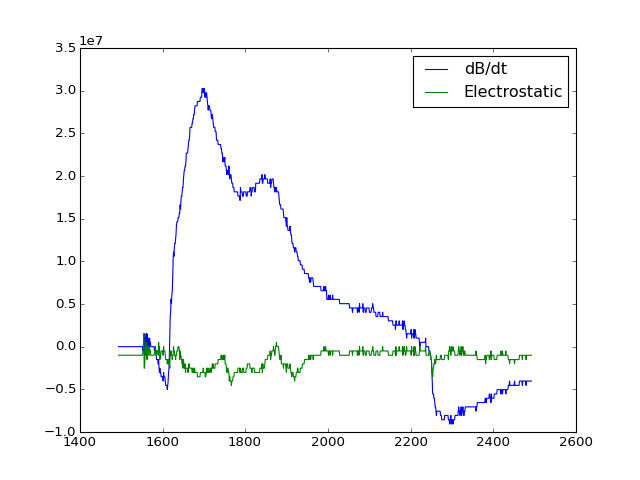

<IPython.core.display.Javascript object>


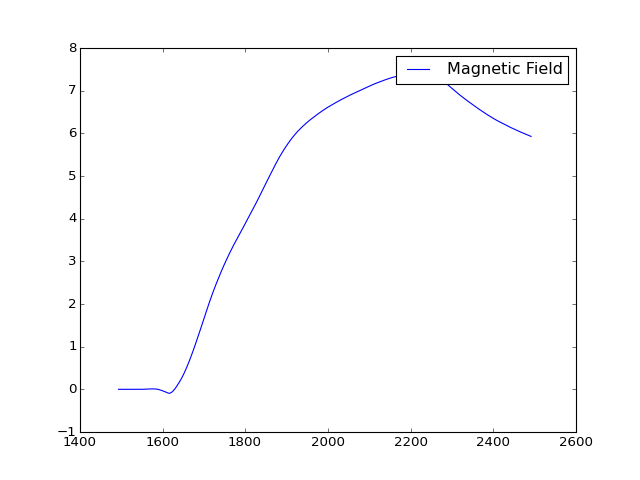

In [73]:
bd3.truncate(threshold=1,calibration=cal)
bd3.add()
bd3.subtract()
bd3.plot_estat_dBdt()
bd3.integrate()
bd3.plot_B()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


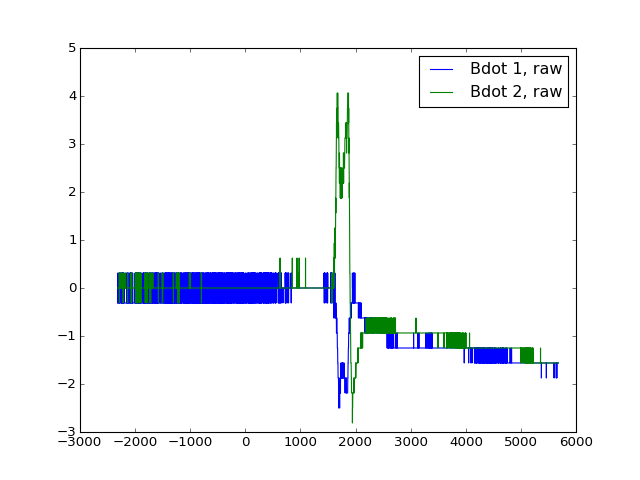

In [74]:
cal=-np.array([20/2.7, 20/2.7])*1e6 #a1 and a2
#cal=np.array([10/3.1, 10/3.1])*1e6 #b1 and b2 and d1 and d2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6 #c1 and c2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6
bd3=Bdot_pair("s0724_13 bdots.dat", bdot1='a1', bdot2='a2')
bd3.plot_raw()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


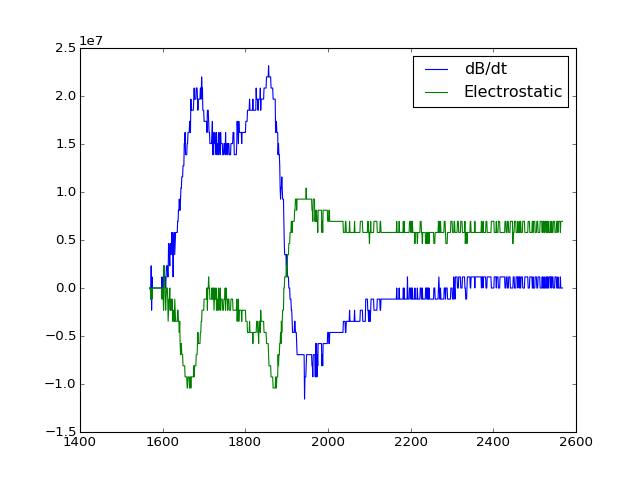

<IPython.core.display.Javascript object>


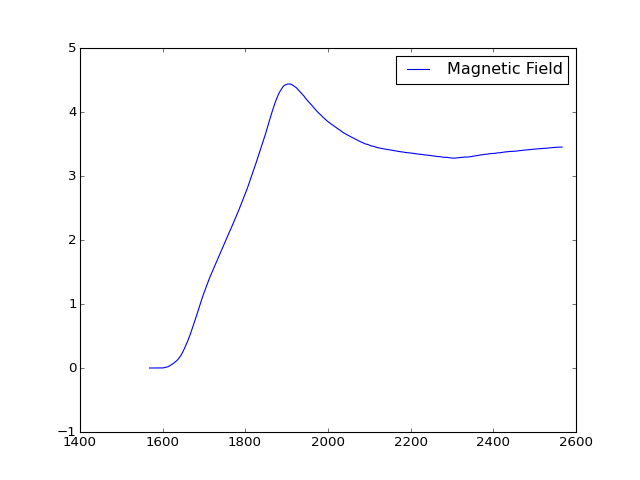

In [75]:
bd3.truncate(threshold=1,calibration=cal)
bd3.add()
bd3.subtract()
bd3.plot_estat_dBdt()
bd3.integrate()
bd3.plot_B()

## s0212_16 

In [4]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\Others"

C:\Users\jdavies\Google Drive\MAGPIE\data\Others


C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


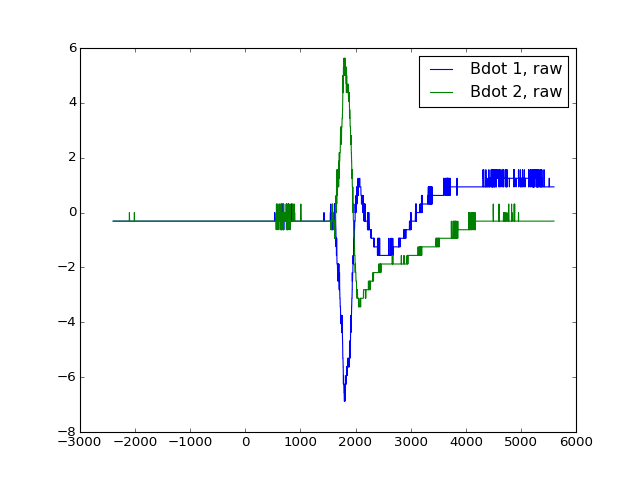

In [27]:
#cal=-np.array([20/3.1, 20/3.1])*1e6 #a1 and a2
cal=-np.array([2/0.2, 2/0.2])*1e6 #b1 and b2
#cal=np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6 #c1 and c2
#cal=np.array([2/3.1, 2/3.1])*1e6 #d1 and d2

bd=Bdot_pair("s0212_16 bdots.dat", bdot1='b1', bdot2='b2')
bd.plot_raw()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


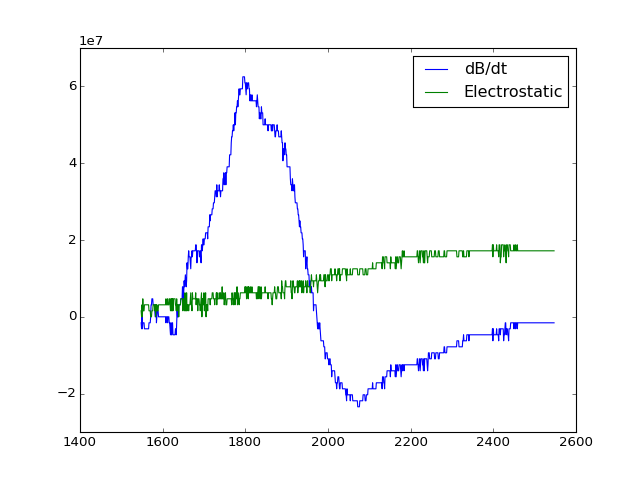

<IPython.core.display.Javascript object>


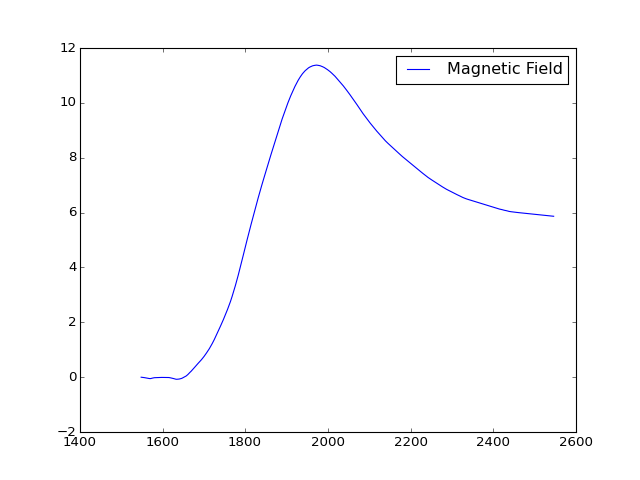

In [28]:
bd.truncate(threshold=1,calibration=cal)
bd.add()
bd.subtract()
bd.plot_estat_dBdt()
bd.integrate()
bd.plot_B()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


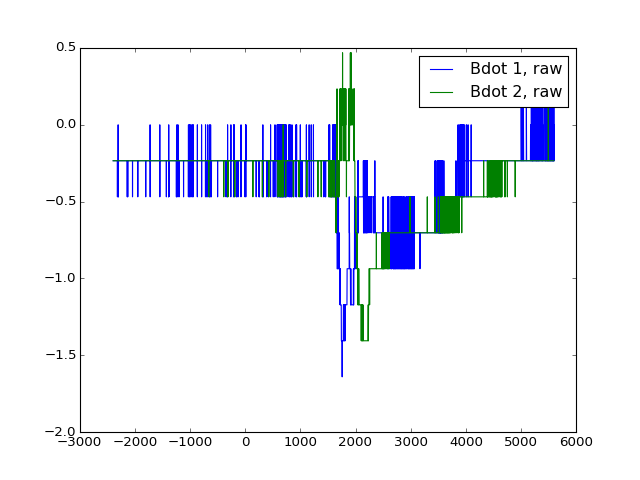

In [29]:
#cal=-np.array([20/3.1, 20/3.1])*1e6 #a1 and a2
#cal=-np.array([2/0.2, 2/0.2])*1e6 #b1 and b2
cal=-np.array([10/(np.pi/4), 10/(np.pi/4)])*1e6 #c1 and c2
#cal=np.array([2/3.1, 2/3.1])*1e6 #d1 and d2

bd2=Bdot_pair("s0212_16 bdots.dat", bdot1='c2', bdot2='c1')
bd2.plot_raw()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


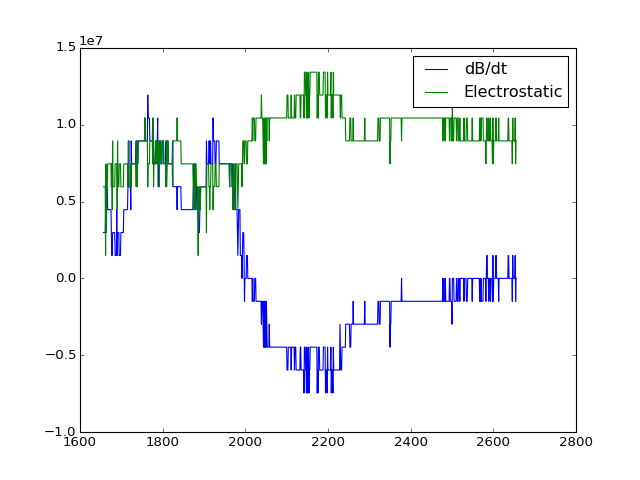

<IPython.core.display.Javascript object>


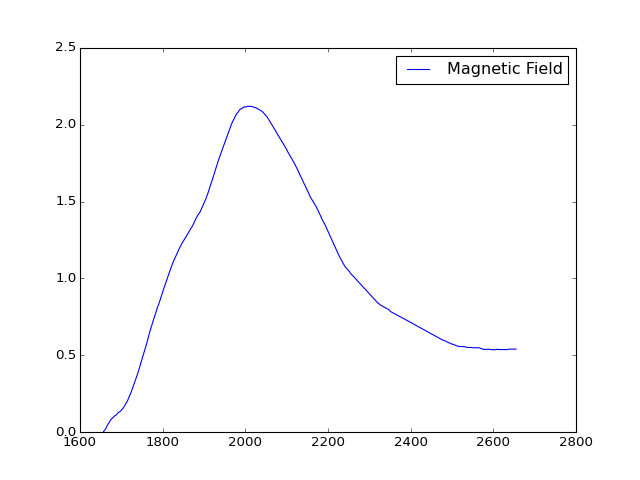

In [30]:
bd2.truncate(threshold=1.5,calibration=cal)
bd2.add()
bd2.subtract()
bd2.plot_estat_dBdt()
bd2.integrate()
bd2.plot_B()

C:\Users\jdavies\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


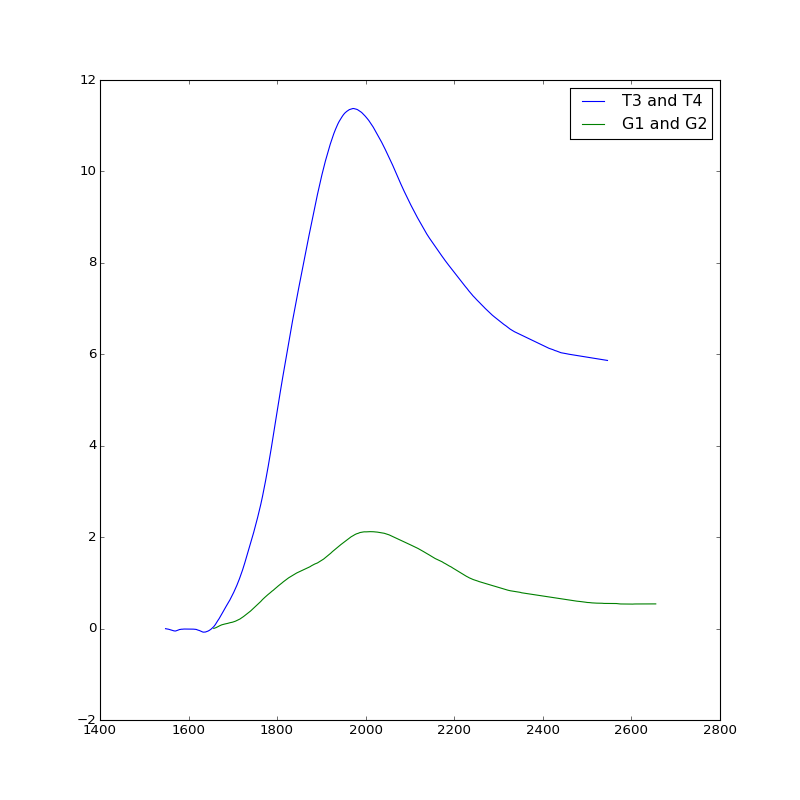

In [32]:
fig, ax=plt.subplots(figsize=(10,10))
ax.plot(bd.time_B,bd.B,label='T3 and T4' )
ax.plot(bd2.time_B,bd2.B, label='G1 and G2')
ax.legend()